# L1 - ImageNet pretrained ResNets with STONEFLY9 dataset<br><br>Activations with hooks (work in progress)

In this notebook a ImageNet pretrained ResNet trained on the [STONEFLY9 dataset](http://web.engr.oregonstate.edu/~tgd/bugid/stonefly9/) is used to get the activations of the network layers.<br>
The base notebook can be found here: https://github.com/MicPie/fastai_course_v3/blob/master/L1-stonefly.ipynb<br>
(Inspired by: https://github.com/kheyer/ML-DL-Projects/blob/master/Pets%20TSNE/pets_tsne.ipynb)

## Notebook setup

In [1]:
# notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai library
from fastai import *
from fastai.vision import *

## Data setup

In [3]:
# set path to data directory
path = Path('/home/paperspace/fastai/data/stonefly')

In [4]:
size = 224 # image size used for training (Note: is only applied when ds_tfms are set)
bs = 64 # batchsize for training

### Dataframe setup

In [5]:
# read in text file with a list of all the files
df = pd.read_csv(path/'files.txt', sep=' ', header=None, names=['imgurl'])

In [6]:
# define string manipulation lambda function to get path after the defined path variable
f = lambda x: x.split('/', 6)[-1]
df['imgurl'] = df['imgurl'].apply(f)

In [7]:
# define string manipulation lambda function to get data class
f = lambda x: x.split('/')[-3]
df['class'] = df['imgurl'].apply(f)

In [358]:
# verify dataframe
#df.head()

In [359]:
#df.tail()

### ImageDataBunch setup

In [8]:
data = ImageDataBunch.from_df(path, df, ds_tfms=get_transforms(), size=size, bs=bs)

In [9]:
# normalize data with the imagent_stats
data.normalize(imagenet_stats);

In [55]:
# length of the training and validation dataset
len(data.train_ds.ds.x), len(data.valid_ds.ds.x)

(3043, 802)

## Setup model with hooks

In [23]:
!gpustat

psbtmxtmo  Mon Oct 29 14:59:13 2018
[0] Quadro P4000     | 36'C,   0 % |   669 /  8119 MB | paperspace(659M)


In [24]:
# From https://forums.fast.ai/t/share-your-work-here/27676/30
class StoreHook(HookCallback):
    def on_train_begin(self, **kwargs):
        super().on_train_begin(**kwargs)
        self.acts = []
    def hook(self, m, i, o): return o
    #def on_batch_end(self, train, **kwargs): self.acts.append(self.hooks.stored)
    def on_train_end(self, train, **kwargs): self.acts = self.hooks.stored

In [25]:
learn = create_cnn(data, models.resnet34, metrics=accuracy, callback_fns=StoreHook)

In [26]:
learn.load('stonefly_resnet34_stage_2')

In [27]:
!gpustat

psbtmxtmo  Mon Oct 29 14:59:20 2018
[0] Quadro P4000     | 37'C,   0 % |   669 /  8119 MB | paperspace(659M)


### Train one epoch to get activations

In [48]:
learn.fit_one_cycle(1)

Total time: 00:43
epoch  train_loss  valid_loss  accuracy
1      0.044053    0.012298    0.995012  (00:43)



## Look at the model structure and the hooks

In [67]:
# original ResNet34 model
#learn.model

In [323]:
# show modules with hooks
#learn.store_hook
#learn.store_hook.modules

In [68]:
# number of activation hooks?
len(learn.store_hook.modules)

76

In [61]:
# show stored activations
[learn.store_hook.acts[i].shape for i in range(len(learn.store_hook.acts))]

[torch.Size([34, 64, 112, 112]),
 torch.Size([34, 64, 112, 112]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 64, 56, 56]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 128, 28, 28]),
 torch.Size([34, 1

In [360]:
learn.store_hook.acts[0].shape

torch.Size([34, 64, 112, 112])

**Interpretation of data dimensions in learn.store_hook.acts:**<br>
1. dimension: layer (0-75)<br>
2. dimension: image?<br>
3. dimension: filter layer<br>
3. & 4. dimension: 2D activations

## Show activations

In [357]:
# How to get the original image?

## Show activations

### Show conv2d activations

In [325]:
# Show conv2d layer activation function
def show_conv2d_act(l=0, nrows=3, ncols=9, s=12, cmap='gist_heat'):
    '''Show p*p activation visualizations of the l-th layer with figsize s*s'''
    fig, axes = plt.subplots(nrows, ncols, figsize=(s,s/3))
    fig.subplots_adjust(hspace=0.1, wspace=0, left=0, right=1, top=1, bottom=0)
    for i, ax in enumerate(axes.flat):
        ax.imshow(learn.store_hook.acts[l][0][i].cpu(), cmap=cmap)
        ax.set_axis_off()

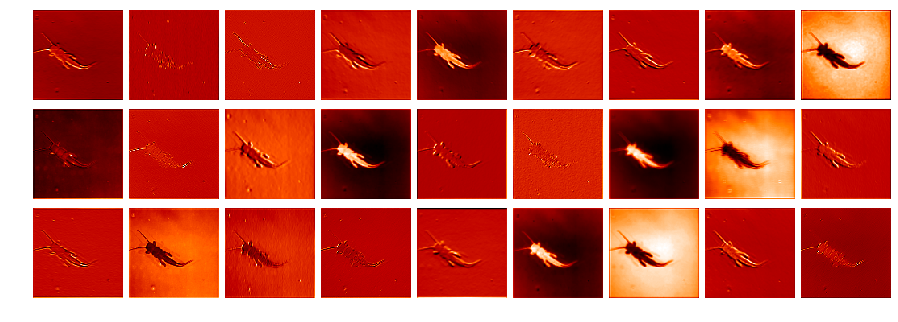

In [326]:
# 1. layer
show_conv2d_act()

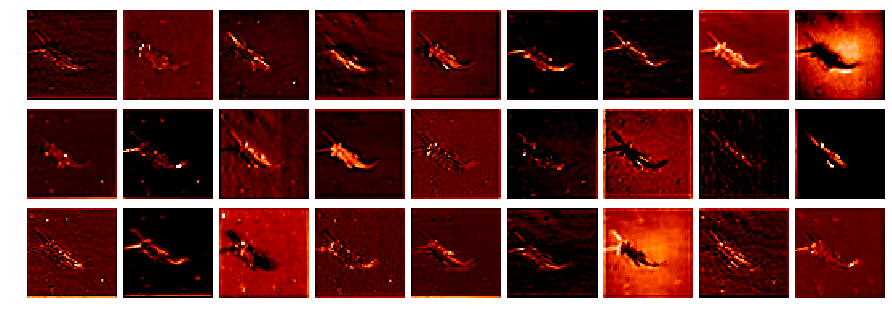

In [292]:
# 10. layer
show_conv2d_act(9)

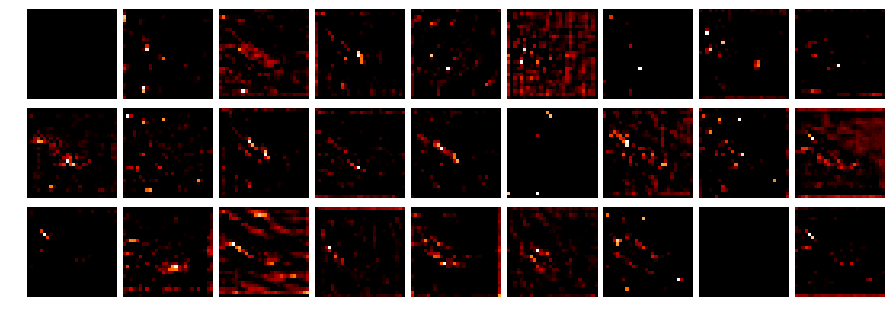

In [293]:
# 30. layer
show_conv2d_act(29)

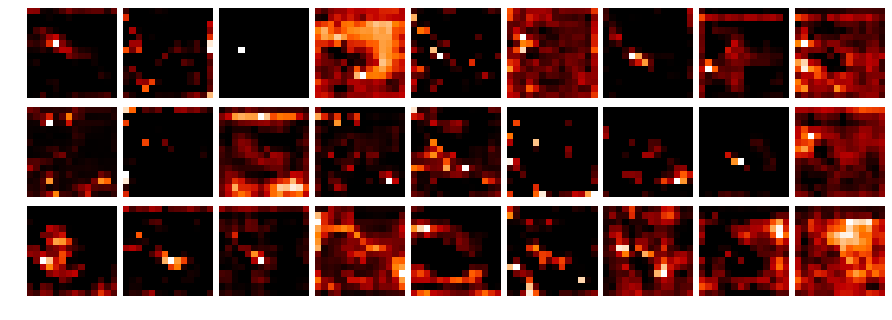

In [294]:
# 50. layer
show_conv2d_act(49)

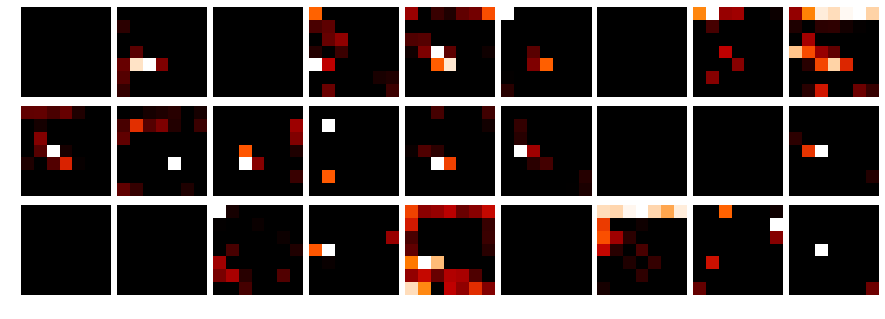

In [295]:
# 60. layer
show_conv2d_act(59)

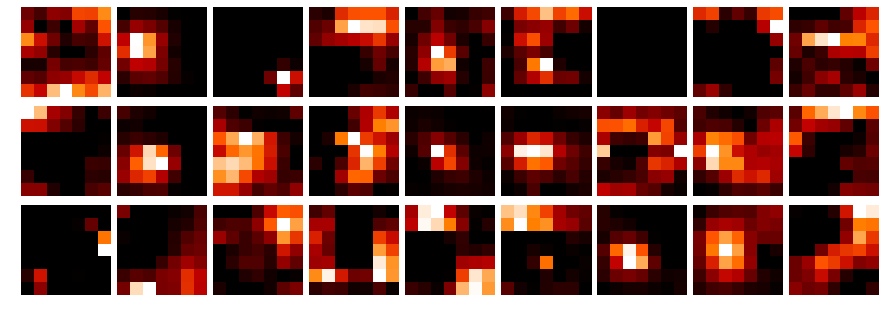

In [296]:
# 72. layer
show_conv2d_act(71)

### Show flattened layer activations

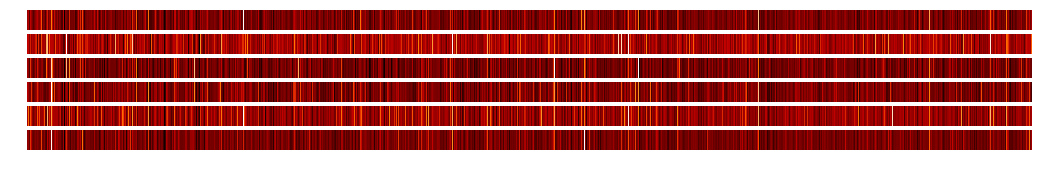

In [365]:
# 72. layer = 1. flattened layer
p = 6 # number of plots
s = 18 # plot width
cmap='gist_heat' # color map
fig, axes = plt.subplots(p,1, figsize=(s,s/7))
for i, ax in enumerate(axes.flat):
    img_data = np.empty((20,learn.store_hook.acts[72][i].cpu().numpy().shape[0])) # create empty numpy array
    img_data[0:] = learn.store_hook.acts[72][i].cpu().numpy() # copy activation array for better visualization
    ax.imshow(img_data, cmap=cmap)
    ax.set_axis_off()

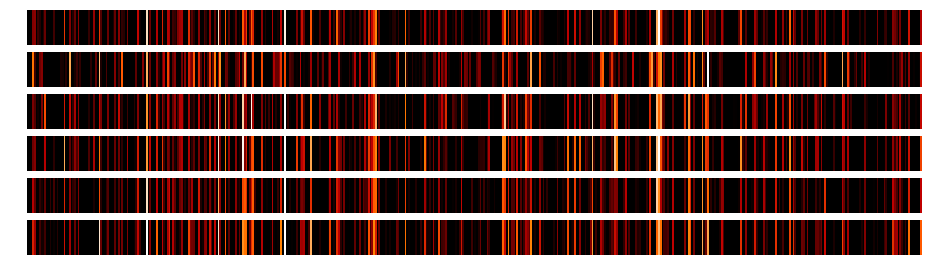

In [337]:
# 73. layer = 2. flattened layer
p = 6 # number of plots
s = 18 # plot width
cmap='gist_heat' # color map
fig, axes = plt.subplots(p,1, figsize=(s,s/4))
for i, ax in enumerate(axes.flat):
    img_data = np.empty((20,learn.store_hook.acts[73][i].cpu().numpy().shape[0])) # create empty numpy array
    img_data[0:] = learn.store_hook.acts[73][i].cpu().numpy() # copy activation array for better visualization
    ax.imshow(img_data, cmap=cmap)
    ax.set_axis_off()

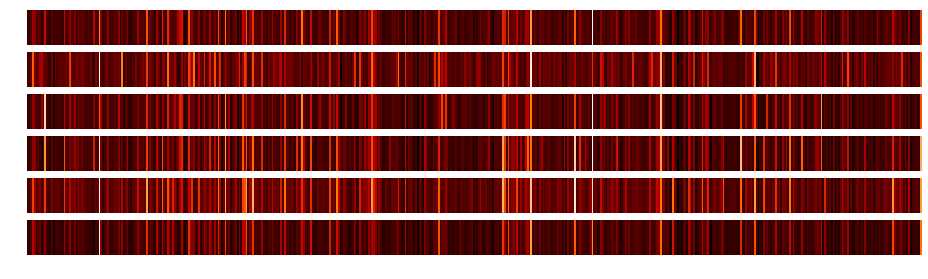

In [331]:
# 74. layer = 3. flattened layer
p = 6 # number of plots
s = 18 # plot width
cmap='gist_heat' # color map
fig, axes = plt.subplots(p,1, figsize=(s,s/4))
for i, ax in enumerate(axes.flat):
    img_data = np.empty((20,learn.store_hook.acts[74][i].cpu().numpy().shape[0])) # create empty numpy array
    img_data[0:] = learn.store_hook.acts[74][i].cpu().numpy() # copy activation array for better visualization
    ax.imshow(img_data, cmap=cmap)
    ax.set_axis_off()

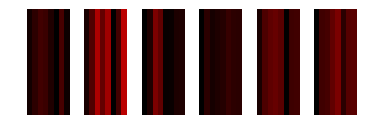

In [366]:
# 75. layer = 3. flattened layer = final layer for classification for 9 classes
p = 6 # number of plots
cmap='gist_heat' # color map
fig, axes = plt.subplots(1,p, figsize=(6,2))
for i, ax in enumerate(axes.flat):
    img_data = np.empty((20,learn.store_hook.acts[75][i].cpu().numpy().shape[0])) # create empty numpy array
    img_data[0:] = learn.store_hook.acts[75][i].cpu().numpy() # copy activation array for better visualization
    ax.imshow(img_data, cmap=cmap)
    ax.set_axis_off()